<a href="https://colab.research.google.com/github/tulaycetin/Veri_Azaltma_Yontemleri/blob/main/Veri_Azaltma_yontemleri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Kütüphanelerin Yüklenmesi**

In [92]:
# Gerekli kütüphanelerin yüklenmesi
import kagglehub
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ***2. Veri Setinin İndirilmesi ve İlk İncelemesikalın metin***

Kaggle’dan NFL Play-by-Play (2009-2016) veri seti indirilir. Bu veri seti, NFL maçlarındaki her bir oyun anını detaylı olarak içerir.
Bu veri seti, NFL maçlarındaki oyunların detaylı verilerini içerdiğinden, maçın kazanılıp kazanılmaması (örneğin, win probability) gibi durumların analizine olanak tanır.


In [93]:
# Veri Setini İndirme ve Ön İnceleme
# ---------------------------
# Kaggle veri setini indiriyoruz.
path = kagglehub.dataset_download("maxhorowitz/nflplaybyplay2009to2016")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nflplaybyplay2009to2016


In [94]:
# CSV dosyasını okuyoruz.
df = pd.read_csv(path + '/NFL Play by Play 2009-2017 (v4).csv')
print("İlk 5 satır:")
print(df.head())

<ipython-input-94-62ee87502347>:2: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + '/NFL Play by Play 2009-2017 (v4).csv')


İlk 5 satır:
         Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0  2009-09-10  2009091000      1    1   NaN  15:00         15    3600.0   
1  2009-09-10  2009091000      1    1   1.0  14:53         15    3593.0   
2  2009-09-10  2009091000      1    1   2.0  14:16         15    3556.0   
3  2009-09-10  2009091000      1    1   3.0  13:35         14    3515.0   
4  2009-09-10  2009091000      1    1   4.0  13:27         14    3507.0   

   PlayTimeDiff SideofField  ...    yacEPA  Home_WP_pre  Away_WP_pre  \
0           0.0         TEN  ...       NaN     0.485675     0.514325   
1           7.0         PIT  ...  1.146076     0.546433     0.453567   
2          37.0         PIT  ...       NaN     0.551088     0.448912   
3          41.0         PIT  ... -5.031425     0.510793     0.489207   
4           8.0         PIT  ...       NaN     0.461217     0.538783   

   Home_WP_post  Away_WP_post  Win_Prob       WPA    airWPA    yacWPA  Season  
0      0.546433      0.

In [95]:
# Veri setinin 10,000 rastgele gözlemini alıyoruz.
df = df.sample(n=20000, random_state=42)
print("Yeni örneklem boyutu:", df.shape)

Yeni örneklem boyutu: (20000, 102)


In [96]:
# Eksik değer sayısı
print("Eksik değerler:")
print(df.isna().sum())

Eksik değerler:
Date            0
GameID          0
Drive           0
qtr             0
down         3009
            ...  
Win_Prob     1269
WPA           262
airWPA      12202
yacWPA      12213
Season          0
Length: 102, dtype: int64


# **3. Eksik Verilerin MICE Yöntemiyle Doldurulmasıkalın metin**

Sadece sayısal değişkenler (numeric_cols) üzerinde çalışıyoruz; çünkü IterativeImputer sürekli değişkenlerle en iyi sonuç verir.

MICE (Multiple Imputation by Chained Equations) yaklaşımı: her bir eksik değerli sütunu diğer sütunlarla regresyon/probabilistik model kurarak sırayla doldurur. Bu, basit ortalama ya da medyan atamadan daha tutarlı sonuçlar verir.

In [97]:
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer'ı etkinleştirir.
from sklearn.impute import IterativeImputer

# Sadece sayısal sütunları seçiyoruz.
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

imputer = IterativeImputer(random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=numeric_cols) #İmputer, df_numeric üzerindeki eksik verileri diğer sütunlarla ilişki kurarak doldurur.



# **4. Hedef ve Bağımsız Değişkenlerin Ayrılması**

Touchdown hedef değişken olarak seçiliyor.

Diğer tüm sayısal sütunlar bağımsız değişken.

In [98]:
# 3. Hedef ve Özellik Matrisi
y = (df_imputed['Touchdown'] >= 0.5).astype(int)
X = df_imputed.drop(columns=['Touchdown'])


# **5. Özellik Ölçekleme (Eksik)**

SVM ve boyut indirgeme yöntemleri ölçek duyarlı olduğundan her özelliği “ortalama = 0, standart sapma = 1” olacak şekilde dönüştürüyoruz.

In [99]:
# 9) Özellik ölçeklendirme
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# **6. PCA ile Boyut İndirgeme**

PCA: Verideki varyansın %90’ını koruyacak şekilde boyut indirgeme yapıyor.

Amaç: Gürültüyü azaltıp hesaplama yükünü hafifletmek.


In [100]:
from sklearn.decomposition import PCA

# PCA ile boyut indirgeme (varyansın %90'ını koru)
pca = PCA(n_components=0.90, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print("PCA sonrası bileşen sayısı:", X_pca.shape[1])


PCA sonrası bileşen sayısı: 27


# **7. LDA ile Boyut İndirgeme**



*   LDA: Sınıflar arası ayrımı maksimize eden doğrusal kombinasyonlar bulur.
*  İkili sınıflandırma için en fazla 1 bileşen verir (sınıf sayısı − 1).



In [101]:
# Win_Prob'u sınıfa çeviriyoruz (örnek: 0.5 üstü = 'kazanır')
y_class = y.values

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_scaled, y_class)

print("LDA sonrası boyut sayısı:", X_lda.shape[1])


LDA sonrası boyut sayısı: 1


# **8. Özellik Seçimi (SelectKBest + mutual_info_classif)**

Mutual information (karşılıklı bilgi) tabanlı en iyi 20 özelliği seçiyoruz. Bu, hedef değişkenle en fazla bağımlılığı taşıyan özellikleri belirler.

In [102]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# En iyi 20 özelliği seçecek
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y_class)

# Seçilen sütun isimlerini görelim
selected_columns = X.columns[selector.get_support()]
print("Seçilen öznitelikler:\n", selected_columns)


Seçilen öznitelikler:
 Index(['yrdline100', 'ydsnet', 'GoalToGo', 'Yards.Gained', 'sp',
       'FieldGoalDistance', 'Opp_Field_Goal_Prob', 'Opp_Safety_Prob',
       'Opp_Touchdown_Prob', 'Touchdown_Prob', 'ExpPts', 'EPA', 'yacEPA',
       'WPA', 'yacWPA'],
      dtype='object')


# **10. SVM ile sınıflandırma ve değerlendirme**

**train_test_split** ile veriyi %80 eğitim, %20 test olarak bölüyor.

Kategorik değişken yoksa değişiklik olmuyor, ama pipeline genelleşti.

**SVC (RBF kernel) ile sınıflandırma:** class_weight='balanced' dengesiz sınıflar için ağırlık atar.

**predict_proba** ile olasılık çıktısı alınıp eşik değere (0.5) göre sınıf tahmini yapılıyor.

Başarıyı; **doğruluk** (accuracy), **AUC**, **karışıklık matrisi** (confusion matrix) ve **sınıflandırma raporu** (precision/recall/f1) ile değerlendiriyoruz.

**ROC** eğrisini çizerek modelin ayırt etme kabiliyetine bakıyoruz.

In [103]:
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_curve, auc
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

def SVMClassifierModel(X, y, threshold=0.5, name="Model"):
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # one-hot (eğer kategorik yoksa zaten aynısı kalır)
    X_train, X_test = pd.get_dummies(X_train, drop_first=True), pd.get_dummies(X_test, drop_first=True)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # model
    svm = SVC(kernel='rbf', C=1.0, gamma='scale',
              probability=True, class_weight='balanced')
    svm.fit(X_train, y_train)

    # predict
    y_proba = svm.predict_proba(X_test)[:,1]
    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"\n==={name}===\nAccuracy: {acc:.3f} — AUC: {roc_auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # ROC plot
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC — {name}')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

    return {'model': svm, 'accuracy': acc, 'auc': roc_auc}


# **11. Tüm veri dönüşümlerinin karşılaştırmalı değerlendirmesi**


===Orijinal===
Accuracy: 0.998 — AUC: 1.000
Confusion Matrix:
 [[3889    4]
 [   3  104]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       0.96      0.97      0.97       107

    accuracy                           1.00      4000
   macro avg       0.98      0.99      0.98      4000
weighted avg       1.00      1.00      1.00      4000



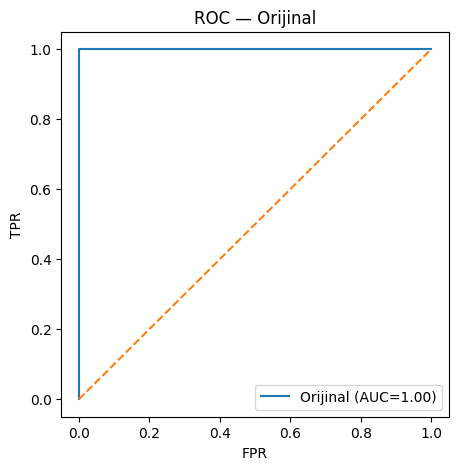


===PCA===
Accuracy: 0.998 — AUC: 1.000
Confusion Matrix:
 [[3888    5]
 [   4  103]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       0.95      0.96      0.96       107

    accuracy                           1.00      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       1.00      1.00      1.00      4000



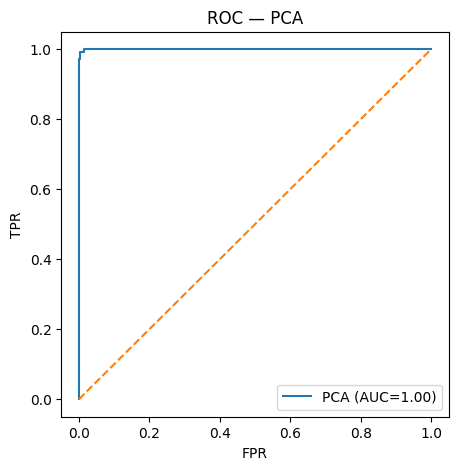


===LDA===
Accuracy: 0.999 — AUC: 0.999
Confusion Matrix:
 [[3890    3]
 [   3  104]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       0.97      0.97      0.97       107

    accuracy                           1.00      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



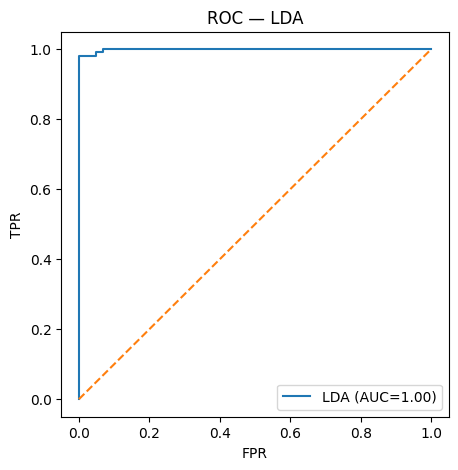


===SelectKBest===
Accuracy: 0.998 — AUC: 0.992
Confusion Matrix:
 [[3890    3]
 [   5  102]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       0.97      0.95      0.96       107

    accuracy                           1.00      4000
   macro avg       0.99      0.98      0.98      4000
weighted avg       1.00      1.00      1.00      4000



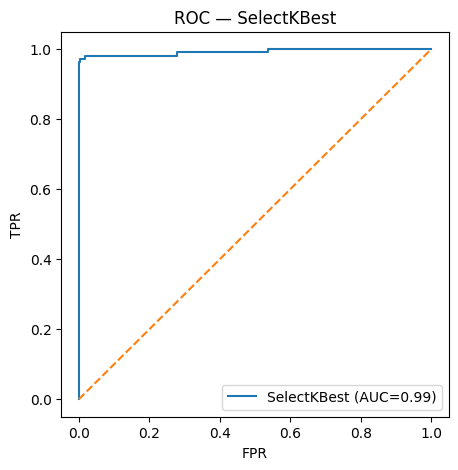

In [104]:
# 1) Orijinal ölçekli veri
X_orig = pd.DataFrame(X_scaled, columns=X.columns)
y_cls  = y_class

# 2) PCA ile
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# 3) LDA ile
X_lda_df = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(X_lda.shape[1])])

# 4) SelectKBest ile
X_sel_df = pd.DataFrame(X_selected, columns=selected_columns)

# Evaluate all
results = {}
results['Orijinal']        = SVMClassifierModel(X_orig,   y_cls, name='Orijinal')
results['PCA']             = SVMClassifierModel(X_pca_df, y_cls, name='PCA')
results['LDA']             = SVMClassifierModel(X_lda_df, y_cls, name='LDA')
results['SelectKBest(20)'] = SVMClassifierModel(X_sel_df, y_cls, name='SelectKBest')



**Neden bu adımlar?**

---


Eksik verileri MICE ile doldurmak, basit yöntemlere göre (ortalama, medyan) daha tutarlı sonuç verir.

Ölçeklendirme, SVM ve PCA gibi yöntemler için şarttır; aksi halde farklı ölçeklerdeki özellikler baskın olur.

Boyut indirgeme (PCA, LDA) ve özellik seçimi (SelectKBest) modeli hem hızlandırır hem de gürültüyü azaltarak genelleme kabiliyetini artırabilir.

SVM dengeli sınıflandırma yeteneği ve güçlü ayırt etme kabiliyeti ile bu tür ikili sınıflandırma problemlerinde sık kullanılır.

ROC/AUC tek bir eşik değere bağlı kalmadan modelin tüm eşiklerdeki performansını özetler.